In [1]:
from sklearn.cluster import KMeans
import sys
# sys.path.insert(1, '../permus_util')
# sys.path.insert(0, '/Users/ekhi/Desktop/gits/top-k-mallows')

import mallows_kendall as mk
import permutil as pu
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import rankdata
from scipy.stats import norm

# Load sushi main and auxilary data

In [28]:
# Read data frame
dfsushi = pd.read_table('sushi3-2016/sushi3a.5000.10.order', sep = ' ', skiprows = 1, 
                        usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], header = None)
print(dfsushi.shape)
print(dfsushi.head)
sushi = np.array(dfsushi)
print(sushi.shape)
print(sushi[:5,:])
# Read auxialary data
dfsushiext = pd.read_table('sushi3-2016/sushi3.udata', sep = '\t', header = None)
print(dfsushiext.shape)
print(dfsushiext.head)
sushiext = np.array(dfsushiext)
print(sushiext.shape)
print(sushiext[:5,:])

(5000, 10)
<bound method NDFrame.head of       2   3   4   5   6   7   8   9   10  11
0      5   0   3   4   6   9   8   1   7   2
1      0   9   6   3   7   2   8   1   5   4
2      7   0   2   3   8   4   5   1   9   6
3      4   5   7   0   2   3   1   6   8   9
4      8   6   5   0   3   9   2   7   4   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
4995   3   7   4   5   6   0   1   2   8   9
4996   7   1   3   8   6   0   5   2   9   4
4997   7   2   4   5   3   6   1   0   8   9
4998   7   2   3   0   8   1   5   9   6   4
4999   0   5   3   4   7   2   6   9   8   1

[5000 rows x 10 columns]>
(5000, 10)
[[5 0 3 4 6 9 8 1 7 2]
 [0 9 6 3 7 2 8 1 5 4]
 [7 0 2 3 8 4 5 1 9 6]
 [4 5 7 0 2 3 1 6 8 9]
 [8 6 5 0 3 9 2 7 4 1]]
(5000, 11)
<bound method NDFrame.head of          0   1   2    3   4   5   6   7   8   9   10
0      6371   0   2  355   0   0   0   0   0   0   0
1     10007   1   1  214  26   6   1  26   6   1   0
2      1777   1   2  363  29   6   1  26   6   1   1
3      3613 

Some first statistics:

In [31]:
print(sum(sushiext[:,9] == 0))
print(sum(sushiext[:,9] == 1))

1552

# Create subsets

In [33]:
sushiEast = sushi[sushiext[:,9] == 0,:]
print(sushiEast.shape)
sushiWest = sushi[sushiext[:,9] == 1,:]
print(sushiWest.shape)

(3448, 10)
(1552, 10)


# Formal testing procedure

To check the guarantee that the performance of the studnets is indeed statistically significantly different after the class, we construct a testing procedure outlined above.

In [34]:
d1 = sushiEast
d2 = sushiWest
print(d1.shape)
print(type(d1))
print(d2.shape)

(3448, 10)
<class 'numpy.ndarray'>
(1552, 10)


## Compile depth library

Compile C++ codes if necessary

In [35]:
# Compilation
# import os
# os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -fPIC  -Wall -g -O2  -c rankDepth.cpp -o rankDepth.o')
# os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -o rankDepth.so rankDepth.o')
# Restart the kernel after this line

Import (and test) the dynamic library

In [36]:
# Import and Test 1
from ctypes import *
cdll.LoadLibrary('rankDepth.so')
libc = CDLL('rankDepth.so')
libc.testFunc()

43

In [37]:
# Test 2
val = np.array([5.1])
obj = np.array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1])
n = 10
outp = np.array([1.1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
res2 = libc.testFuncCmp(c_void_p(val.ctypes.data),
                       c_void_p(obj.ctypes.data),
                       c_int(n),
                       c_void_p(outp.ctypes.data))
print(res2)
print(outp)

0
[  1.1   0.    0.    0.    0.    0.    0.    0.    0.  142. ]


Depth-calculating Python function

In [38]:
def qrdepth(objects, data):
    '''
    The function to calculate the qr-depths
    '''
    depths = np.zeros(objects.shape[0])
    for i in range(objects.shape[0]):
        for j in range(data.shape[0]):
            depths[i] += (mk.max_dist(objects.shape[1]) - mk.distance(objects[i,:], data[j,:])) / mk.max_dist(objects.shape[1])
        depths[i] /= data.shape[0]
    return depths

## Exploratory DD-plot

Plotting DD-plot


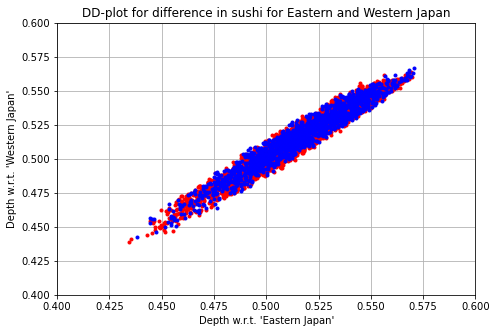

In [50]:
print("Plotting DD-plot")
#depths1 = np.transpose(np.array([qrdepth(d1, d1), qrdepth(d1, d2)]))
#depths2 = np.transpose(np.array([qrdepth(d2, d1), qrdepth(d2, d2)]))
plt.close("all")
plt.figure(1, figsize=(7.5, 5))
plt.title("DD-plot for difference in sushi for Eastern and Western Japan")
plt.plot(depths1[:,0], depths1[:,1], 'r.')
plt.plot(depths2[:,0], depths2[:,1], 'b.')
plt.xlabel("Depth w.r.t. 'Eastern Japan'")
plt.ylabel("Depth w.r.t. 'Western Japan'")
plt.ylim(0.4, 0.6)
plt.xlim(0.4, 0.6)
plt.grid()
plt.savefig("pic-ddplot-sushi.pdf")

Plotting one DD-plot


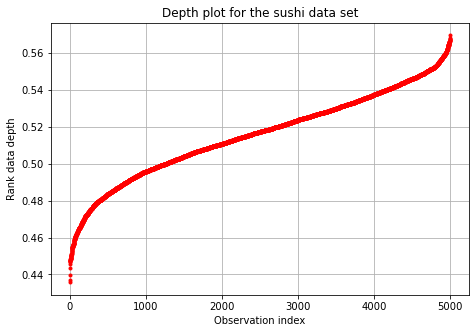

In [51]:
print("Plotting one DD-plot")
#depthsAll = qrdepth(sushi, sushi)
plt.close("all")
plt.figure(1, figsize=(7.5, 5))
plt.title("Depth plot for the sushi data set")
plt.plot(list(range(sushi.shape[0])), np.sort(depthsAll), 'r.')
plt.xlabel("Observation index")
plt.ylabel("Rank data depth")
#plt.ylim(0.4, 0.6)
#plt.xlim(0.4, 0.6)
plt.grid()
plt.savefig("pic-depthplot-sushi.pdf")